# Feed Forward Neural Network
Pada percobaan kali ini kita akan menggunakan dataset MNIST yaitu dataset yang berisi gambar-gambar angka tulisan tangan.

In [11]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

### Menggunakan GPU kalau ada

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Hyperparameter

- input sebesar 794 didapat dari ukuran piksel pada satu buah gambar
- output sebesar 10 didapat dari jumlah kelas yang ada, yaitu angka digit dari 0 - 9

In [27]:
input_size      = 784
hidden_size     = 500
num_classes     = 10    # digit 0-9
num_epochs       = 2
batch_size      = 100
learning_rate   = 0.01

# Mempersiapkan Dataset
Train Test Torchvision menyediakan beberapa datasets yang kerap digunakan pada library torchvision.datasets. Informasi lebih lanjut dapat dilihat pada dokumentasi torchvision.datasets. Khusus untuk dataset MNIST, detail lebih lengkap dapat dilihat pada tautan berikut ini.

- root='./data': Lokasi dataset yang akan digunakan.
- train=True: Menentukan dataset yang digunakan untuk training atau tidak.
- transform=transforms.ToTensor(): Transformasi yang akan dilakukan pada dataset.
- download=True: Download dataset jika belum ada.

DataLoader Detail tentang DataLoader dapat dilihat pada dokumentasi berikut ini.

- dataset: Dataset yang akan digunakan.
- batch_size: Banyaknya data yang akan dibatasi dalam satu batch
- shuffle: Untuk membuat data diacak atau tidak.

In [14]:
train_dataset   = torchvision.datasets.MNIST(root='./34_data',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)

In [15]:
test_dataset    = torchvision.datasets.MNIST(root='./34_data',
                                           train=False,
                                           transform=transforms.ToTensor())

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [20]:
example_batch   = iter(train_loader)
samples, labels = next(example_batch)       # samples, labels = example_batch.next()
print(f"Ukuran sample:  {samples.shape}")
print(f"Ukuran label :  {labels.shape}")

Ukuran sample:  torch.Size([100, 1, 28, 28])
Ukuran label :  torch.Size([100])


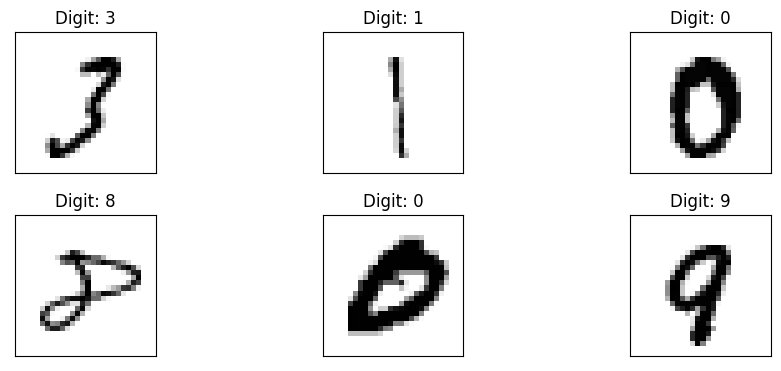

In [21]:
# show 6 samples image with label using subplot
fig = plt.figure(figsize=(10,4))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(samples[i][0], cmap='gist_yarg')
    plt.title("Digit: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])

Penjelasan Contoh Data Terdapat 100 sampel data pada contoh batch yang dicetak dimana setiap gambar berukuran 28x28 pixel dan ditransformasi menjadi tensor dengan dimensi (1, 28, 28).

# Define the Model

In [24]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1    = nn.Linear(input_size, hidden_size)
        self.relu   = nn.ReLU()
        self.fc2    = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


# Loss dan Optimizer

- Kita akan menggunakan CrossEntropyLoss untuk menghitung loss.
- Pada loss function itu sudah terdapat Softmax yang akan menghasilkan probabilitas untuk setiap kelas.
- Untuk optimizer, kita akan menggunakan Adam optimizer.
- optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("criterion\n", criterion)
print("optimizer\n", optimizer)

criterion
 CrossEntropyLoss()
optimizer
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


# Training Loop
- images perlu di reshape karena input yang kita gunakan pada neural network berukuran 784
- sebelumnya images memiliki dimensi (1, 28, 28) -> 1 channel, 28 pixel panjang, 28 pixel lebar
- Diubah menjadi array dengan dimensi (1, 784)

In [29]:
n_total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_step}], Loss: {loss.item():.4f}')

Epoch [1/2], Step [100/600], Loss: 0.2766
Epoch [1/2], Step [200/600], Loss: 0.1063
Epoch [1/2], Step [300/600], Loss: 0.1588
Epoch [1/2], Step [400/600], Loss: 0.1395
Epoch [1/2], Step [500/600], Loss: 0.2015
Epoch [1/2], Step [600/600], Loss: 0.1549
Epoch [2/2], Step [100/600], Loss: 0.1782
Epoch [2/2], Step [200/600], Loss: 0.0912
Epoch [2/2], Step [300/600], Loss: 0.2114
Epoch [2/2], Step [400/600], Loss: 0.1434
Epoch [2/2], Step [500/600], Loss: 0.2154
Epoch [2/2], Step [600/600], Loss: 0.0608


# Testing the Model

In [30]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    accuracy = 100.0 * n_correct / n_samples
    print(f'Akurasi: {accuracy}')

Akurasi: 96.93
